# Tutorial 1: Building Your First Diffusion Model (DDPM)

##  Learning Objectives

By the end of this tutorial, you will:
-  Understand the forward diffusion process (adding noise)
-  Implement a neural network to predict noise
-  Train a denoising diffusion probabilistic model
-  Generate new samples via reverse diffusion
-  Visualize the entire process

##  Expected Time: ~25-30 minutes

---

##  Background

### What is a Diffusion Model?

A **Denoising Diffusion Probabilistic Model (DDPM)** is a generative model that learns to generate data by reversing a gradual noising process.

**Key Idea:**
1. **Forward Process**: Gradually add noise to data until it becomes pure Gaussian noise
2. **Reverse Process**: Learn to remove noise step-by-step to generate new samples

### Mathematical Formulation

**Forward Process** (fixed):
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$$

**Reverse Process** (learned):
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

**Training Objective**:
$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

---

## Step 1: Setup and Imports

In [1]:
import os
import matplotlib.pyplot as plt

# Tutorial modules
from ddpm_tutorial.models import SimpleMLPDenoiser
from ddpm_tutorial.diffusion import GaussianDiffusion
from ddpm_tutorial.utils import (
    create_toy_dataset,
    ToyDataLoader,
    set_seed,
    count_parameters,
    get_device,
)
from ddpm_tutorial.visualization import (
    visualize_forward_process,
    visualize_samples,
    plot_training_curves,
    visualize_reverse_process_trajectory,
    create_reverse_process_animation,
    visualize_noise_schedule,
    create_summary_figure,
    visualize_marginal_distributions,
)




In [2]:
# Set random seed for reproducibility
set_seed(42)

# Get device
device = get_device()
print(f"Using device: {device}")

# Create output directory
os.makedirs("outputs", exist_ok=True)
print("Created outputs/ directory")

Using device: cpu
Created outputs/ directory


---

## Step 2: Create a 2D Toy Dataset

We'll use a 2D dataset so we can easily visualize what's happening!

**Available datasets:**
- `"moons"`: Two interleaving half-circles
- `"circles"`: Two concentric circles
- `"swiss_roll"`: Classic swiss roll pattern
- `"two_gaussians"`: Two separated Gaussian blobs
- `"checkerboard"`: Challenging checkerboard pattern

In [3]:
# Configuration
DATASET_TYPE = "moons"  # Change this to try different datasets!
N_SAMPLES = 10000
NOISE = 0.05

# Create dataset
data = create_toy_dataset(
    dataset_type=DATASET_TYPE,
    n_samples=N_SAMPLES,
    noise=NOISE,
)

print(f"Created '{DATASET_TYPE}' dataset")
print(f"  Shape: {data.shape}")
print(f"  Mean: [{data.mean(0)[0]:.3f}, {data.mean(0)[1]:.3f}]")
print(f"  Std:  [{data.std(0)[0]:.3f}, {data.std(0)[1]:.3f}]")

Created 'moons' dataset
  Shape: torch.Size([10000, 2])
  Mean: [-0.000, -0.000]
  Std:  [1.500, 1.500]


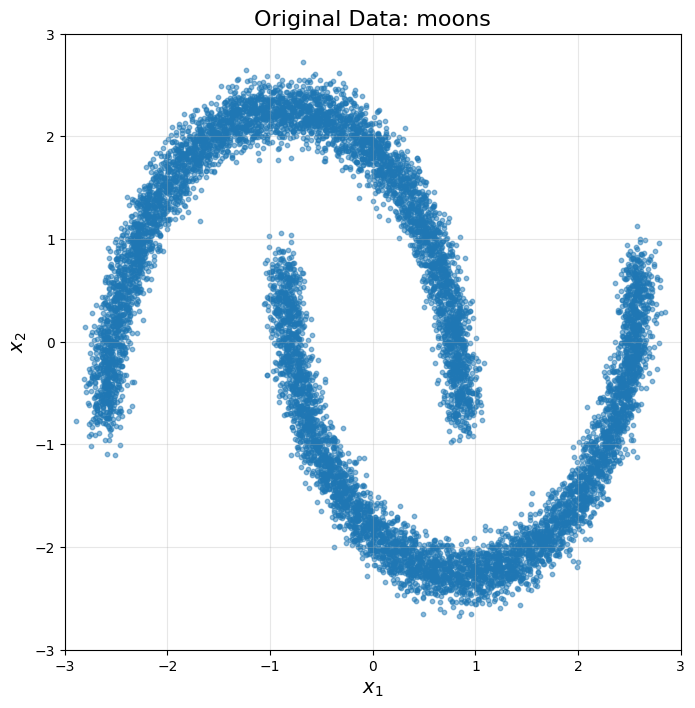

In [4]:
# Visualize the dataset
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'Original Data: {DATASET_TYPE}', fontsize=16)
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal')
plt.show()

###  Question 1

**Why do we use 2D toy datasets for this tutorial?**

<details>
<summary>Click for answer</summary>

2D datasets allow us to:
1. **Visualize** the entire process easily
2. **Train quickly** on limited hardware
3. **Understand** what's happening at each step
4. **Debug** when things go wrong

The same principles apply to high-dimensional data (images, audio, etc.)!
</details>

---

## Step 3: Initialize the Diffusion Process

The diffusion process defines how we add noise over time.

**Key parameters:**
- `n_steps`: Number of diffusion timesteps $T$ (typically 100-1000)
- `beta_start`, `beta_end`: Controls noise schedule $\beta_t$
- `schedule`: Shape of noise schedule ("linear" or "cosine")

In [5]:
# Diffusion configuration
N_STEPS = 100
BETA_START = 1e-4
BETA_END = 0.02
SCHEDULE = "linear"  # Try "cosine" too!

# Create diffusion process
diffusion = GaussianDiffusion(
    n_steps=N_STEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    schedule=SCHEDULE,
    device=device,
)

print(f"Created Gaussian Diffusion with {N_STEPS} steps")
print(f"  Noise schedule: {SCHEDULE}")
print(f"  β range: [{BETA_START}, {BETA_END}]")

Created Gaussian Diffusion with 100 steps
  Noise schedule: linear
  β range: [0.0001, 0.02]


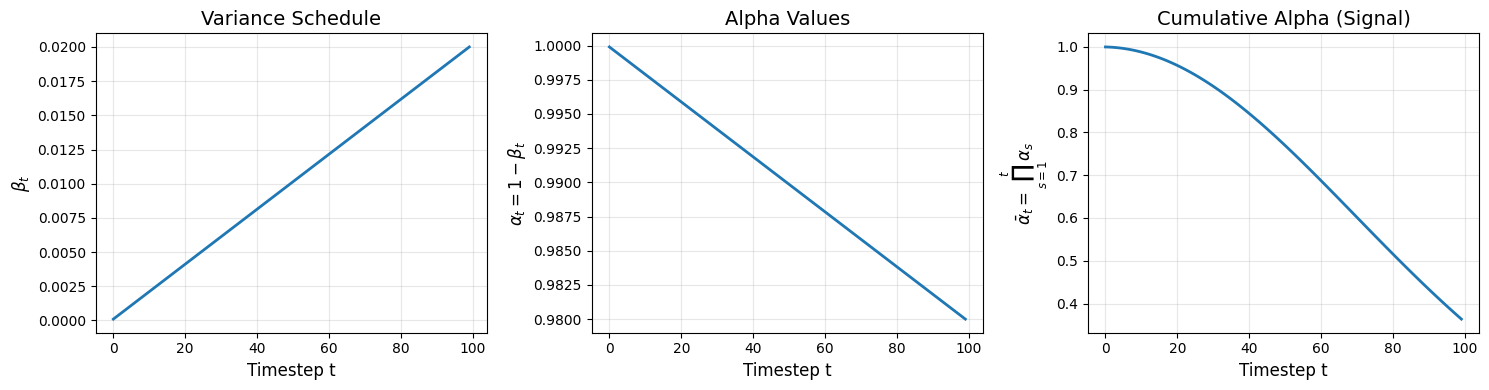

In [6]:
# Visualize the noise schedule
visualize_noise_schedule(diffusion)

###  Understanding the Noise Schedule

- **$\beta_t$**: Variance added at each step (increases over time)
- **$\alpha_t = 1 - \beta_t$**: Signal retention (decreases over time)
- **$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$**: Cumulative signal (approaches 0)

At $t = T$, almost all signal is lost and we have pure noise!

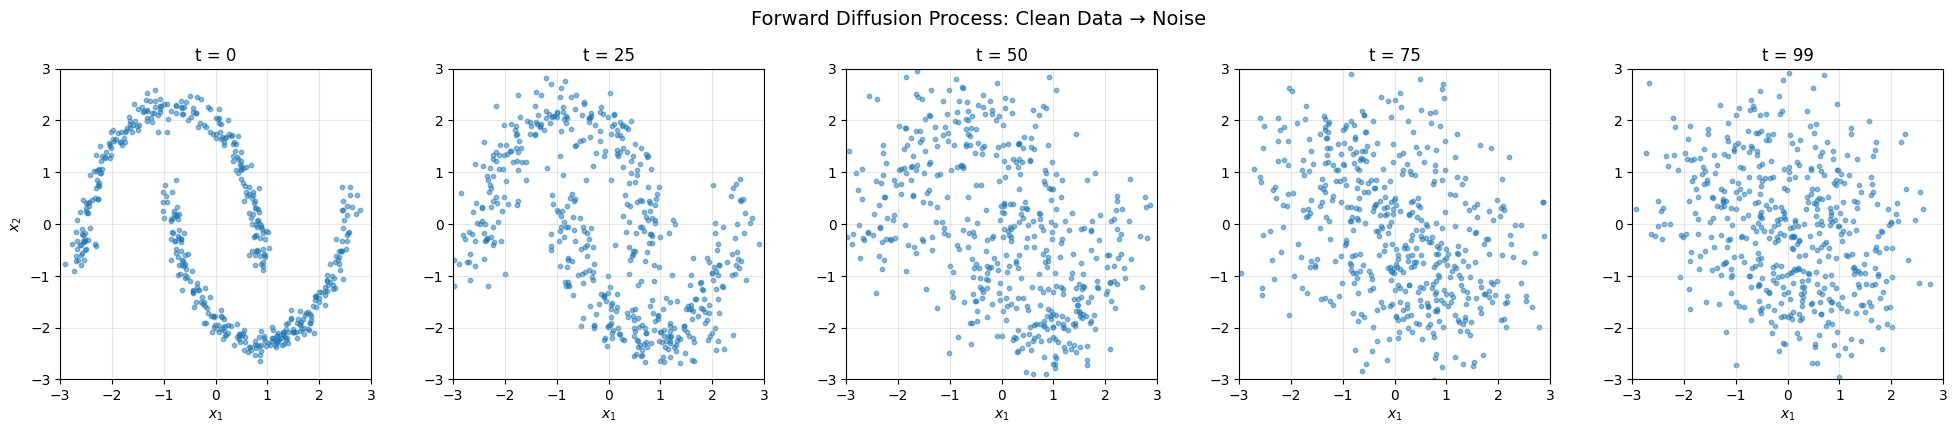

In [7]:
# Visualize forward diffusion: Clean data → Noise
visualize_forward_process(
    diffusion,
    data[:1000],
    timesteps=[0, 25, 50, 75, 99]
)

###  Question 2

**What do you observe as $t$ increases?**

<details>
<summary>Click for answer</summary>

As $t$ increases:
1. The data structure gradually **disappears**
2. Points spread out to fill a **Gaussian blob**
3. At $t = T$, the distribution is approximately **$\mathcal{N}(0, I)$**

This is the **forward process** we will learn to reverse!
</details>

---

## Step 4: Create the Neural Network

We need a network $\epsilon_\theta(x_t, t)$ that predicts the noise given:
- Current noisy data $x_t$
- Current timestep $t$

We'll use a simple **Multi-Layer Perceptron (MLP)** with:
- Sinusoidal time embeddings
- Multiple hidden layers
- ReLU activations

In [8]:
# Model configuration
HIDDEN_DIM = 128
TIME_EMBED_DIM = 32
N_LAYERS = 3

# Create model
model = SimpleMLPDenoiser(
    input_dim=2,
    hidden_dim=HIDDEN_DIM,
    time_embed_dim=TIME_EMBED_DIM,
    n_layers=N_LAYERS,
).to(device)

n_params = count_parameters(model)
print(f"Created SimpleMLPDenoiser")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Time embed dim: {TIME_EMBED_DIM}")
print(f"  Number of layers: {N_LAYERS}")
print(f"  Total parameters: {n_params:,}")

Created SimpleMLPDenoiser
  Hidden dim: 128
  Time embed dim: 32
  Number of layers: 3
  Total parameters: 41,954


###  Model Architecture

```
Input: x_t (2D) + t (scalar)
  ↓
Time Embedding: t → embed_t (TIME_EMBED_DIM)
  ↓
Concatenate: [x_t, embed_t]
  ↓
MLP: Linear → ReLU → ... → Linear
  ↓
Output: ε_pred (2D)
```

The network learns to predict **what noise was added** at each timestep!

---

## Step 5: Train the Model

**Training objective:**
$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

**Algorithm:**
1. Sample clean data $x_0$ from dataset
2. Sample random timestep $t \sim \text{Uniform}(1, T)$
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$
4. Create noisy sample: $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
5. Predict noise: $\epsilon_{\text{pred}} = \epsilon_\theta(x_t, t)$
6. Compute loss: $\mathcal{L} = \|\epsilon - \epsilon_{\text{pred}}\|^2$
7. Update parameters via gradient descent

In [9]:
# Training configuration
BATCH_SIZE = 256
N_EPOCHS = 100
LEARNING_RATE = 1e-3

# Create data loader
data_loader = ToyDataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Training configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of epochs: {N_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batches per epoch: {len(data_loader)}")

NameError: name 'optim' is not defined

In [ ]:
# Training loop
model.train()
losses = []

print("Starting training...\n")

for epoch in range(N_EPOCHS):
    epoch_losses = []
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}")
    
    for batch in pbar:
        batch = batch.to(device)
        
        # Compute loss
        loss = diffusion.training_loss(model, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record
        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    # Average loss
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{N_EPOCHS}, Avg Loss: {avg_loss:.4f}")

print("\n Training complete!")
print(f"Final loss: {losses[-1]:.4f}")

In [ ]:
# Plot training curve
plot_training_curves(losses)

###  Question 3

**What should the loss curve look like?**

<details>
<summary>Click for answer</summary>

A good training curve should:
1. **Start high** (random initialization)
2. **Decrease steadily** (learning)
3. **Plateau** (convergence)

If your loss isn't decreasing:
- Learning rate might be too low
- Model might be too small
- Try training for more epochs
</details>

---

## Step 6: Generate New Samples!

Now for the exciting part - let's generate new samples!

**Reverse sampling algorithm:**
1. Start with pure noise: $x_T \sim \mathcal{N}(0, I)$
2. For $t = T, T-1, ..., 1$:
   - Predict noise: $\epsilon_{\text{pred}} = \epsilon_\theta(x_t, t)$
   - Compute mean: $\mu_\theta(x_t, t)$
   - Sample: $x_{t-1} \sim \mathcal{N}(\mu_\theta, \sigma_t^2 I)$
3. Return $x_0$

In [ ]:
# Generate samples
model.eval()

N_SAMPLES_TO_GENERATE = 1000

print(f"Generating {N_SAMPLES_TO_GENERATE} samples...")

# Generate with trajectory (to visualize the process)
trajectory = diffusion.sample(
    model,
    shape=(N_SAMPLES_TO_GENERATE, 2),
    return_trajectory=True,
)

generated_samples = torch.from_numpy(trajectory[-1])

print(f" Generated {len(generated_samples)} samples!")

In [ ]:
# Visualize reverse sampling process
visualize_reverse_process_trajectory(trajectory, n_frames_to_show=10)

###  Create Animation

Let's create an animation showing the full reverse process!

In [ ]:
# Create animation (this may take a moment)
create_reverse_process_animation(
    trajectory,
    save_path="outputs/reverse_sampling.gif",
    fps=20,
)

print("Animation saved! Check outputs/reverse_sampling.gif")

---

## Step 7: Compare Real vs Generated

The moment of truth - how good are our generated samples?

In [ ]:
# Compare side by side
visualize_samples(
    data[:N_SAMPLES_TO_GENERATE],
    generated_samples,
)

### 1D Marginal Distributions

Let's look at the 1D projections along each dimension separately.
This helps us understand:
- How well each dimension is modeled
- Whether the model captures the marginal distributions
- Quantitative agreement using metrics


In [ ]:
# Visualize 1D marginal distributions with agreement metrics
visualize_marginal_distributions(
    data[:N_SAMPLES_TO_GENERATE],
    generated_samples,
)


### Understanding the Metrics

**Wasserstein Distance** (Earth Mover's Distance):
- Measures the minimum "work" needed to transform one distribution into another
- Lower is better (0 = perfect match)
- Typical good values: < 0.1 for well-trained models

**Histogram Overlap** (Intersection):
- Measures how much the histograms overlap
- Higher is better (1 = perfect overlap)
- Typical good values: > 0.8 for well-trained models

These metrics give us quantitative measures of how well the model learned each marginal distribution!


###  Question 4

**How can you tell if the model learned the distribution well?**

<details>
<summary>Click for answer</summary>

Good generated samples should:
1. **Match the shape** of the real distribution
2. **Cover all modes** (e.g., both moons)
3. **Have similar density** in all regions
4. **Not have obvious artifacts** or clustering

If your samples don't match:
- Train longer
- Use more diffusion steps
- Try a larger model
- Adjust the noise schedule
</details>

---

## Step 8: Create Summary Figure

In [ ]:
# Create comprehensive summary
create_summary_figure(
    data[:N_SAMPLES_TO_GENERATE],
    generated_samples,
    losses,
    diffusion,
    save_path="outputs/ddpm_summary.png",
)

print("Summary figure saved to outputs/ddpm_summary.png")

---

##  Congratulations!

You've successfully:
1.  Implemented a forward diffusion process
2.  Trained a neural network to predict noise
3.  Generated new samples via reverse diffusion
4.  Visualized the entire process

---

##  Experiments to Try

Now that you understand the basics, try these experiments:

### Experiment 1: Different Datasets
Change `DATASET_TYPE` to:
- `"circles"`
- `"swiss_roll"`
- `"two_gaussians"`
- `"checkerboard"` (challenging!)

How does the model perform on each?

### Experiment 2: Noise Schedule
Try `SCHEDULE = "cosine"` instead of `"linear"`

Does it train faster? Better quality?

### Experiment 3: Number of Steps
Change `N_STEPS` to:
- 50 (faster sampling)
- 200 (slower but potentially better)

What's the trade-off?

### Experiment 4: Model Size
Try different:
- `HIDDEN_DIM` (64, 128, 256)
- `N_LAYERS` (2, 3, 4, 5)

Bigger = better quality?

### Experiment 5: Training Time
- Try `N_EPOCHS = 50` vs `N_EPOCHS = 200`

When does it converge?

In [ ]:
# Your experiments here!
# Copy cells from above and modify parameters


---

##  Key Takeaways

1. **Diffusion models** work by reversing a gradual noising process
2. The **forward process** is fixed (just add Gaussian noise)
3. The **reverse process** is learned (neural network predicts noise)
4. **Training** is simple: predict the noise that was added
5. **Sampling** is iterative: gradually denoise from pure noise
6. **Noise schedules** matter (linear vs. cosine)
7. **More steps** = better quality but slower sampling

---

##  Next Steps

Ready to learn more?

1. **Tutorial 2**: Flow Matching from Scratch
   - Learn about continuous normalizing flows
   - Understand velocity fields vs. score functions
   - Compare with diffusion models

2. **Tutorial 3**: Diffusion vs. Flow Matching
   - Side-by-side comparison
   - Different samplers (DDPM, DDIM, Euler, RK45)
   - Performance benchmarking

3. **Read the Papers**:
   - [Denoising Diffusion Probabilistic Models (DDPM)](https://arxiv.org/abs/2006.11239)
   - [Improved DDPM](https://arxiv.org/abs/2102.09672)
   - [Score-Based Generative Modeling](https://arxiv.org/abs/2011.13456)

4. **Scale Up**:
   - Try on image datasets (MNIST, CIFAR-10)
   - Implement conditional generation
   - Add classifier guidance

---

##  Questions and Answers

### Q: Why does training take so long?
**A:** The network needs to learn to denoise at ALL timesteps (0 to T). Each batch trains on random timesteps, so it takes many iterations to cover all well.

### Q: Can I use this for images?
**A:** Yes! The same principles apply. You'd need:
- CNN/U-Net architecture instead of MLP
- More timesteps (e.g., 1000)
- More training time

### Q: What's the difference between DDPM and Score Matching?
**A:** They're actually equivalent! DDPM predicts noise, score matching predicts the score (gradient of log probability). They're just different parameterizations.

### Q: Why add noise in the first place?
**A:** It provides a clear path from data to a simple distribution (Gaussian). The model learns to reverse this path, enabling generation.

---

##  You Did It!

You've completed Tutorial 1: Building Your First Diffusion Model!

**What you learned:**
- Forward and reverse diffusion processes
- Training a noise prediction network
- Generating samples from noise
- The role of noise schedules

**Keep exploring and have fun with generative models! **